附件1数据维度: (114, 10)
附件2数据维度: (7, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   催化剂组合编号                    21 non-null     object 
 1   催化剂组合                      21 non-null     object 
 2   温度                         114 non-null    int64  
 3   乙醇转化率(%)                   114 non-null    float64
 4   乙烯选择性（%）                   114 non-null    float64
 5   C4烯烃选择性(%)                 114 non-null    float64
 6   乙醛选择性(%)                   114 non-null    float64
 7   碳数为4-12脂肪醇         选择性(%)  114 non-null    float64
 8   甲基苯甲醛和甲基苯甲醇选择性(%)          114 non-null    float64
 9   其他生成物的选择性(%)               114 non-null    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 9.0+ KB
填充后缺失值:
催化剂组合编号                      0
催化剂组合                        0
温度                           0
乙醇转化率(%)                 

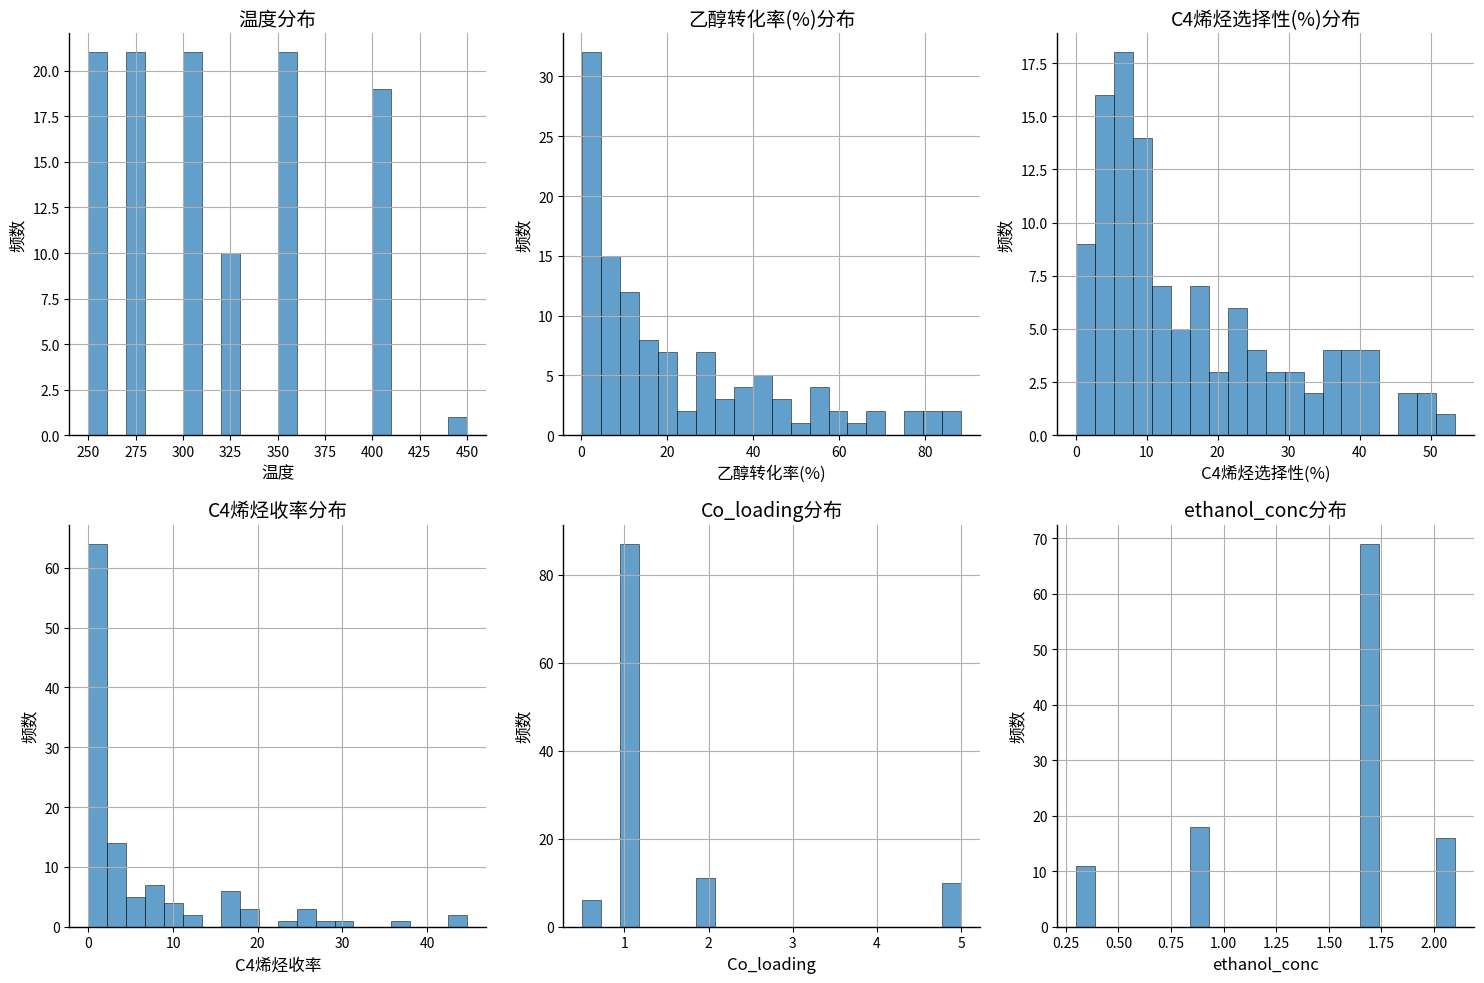

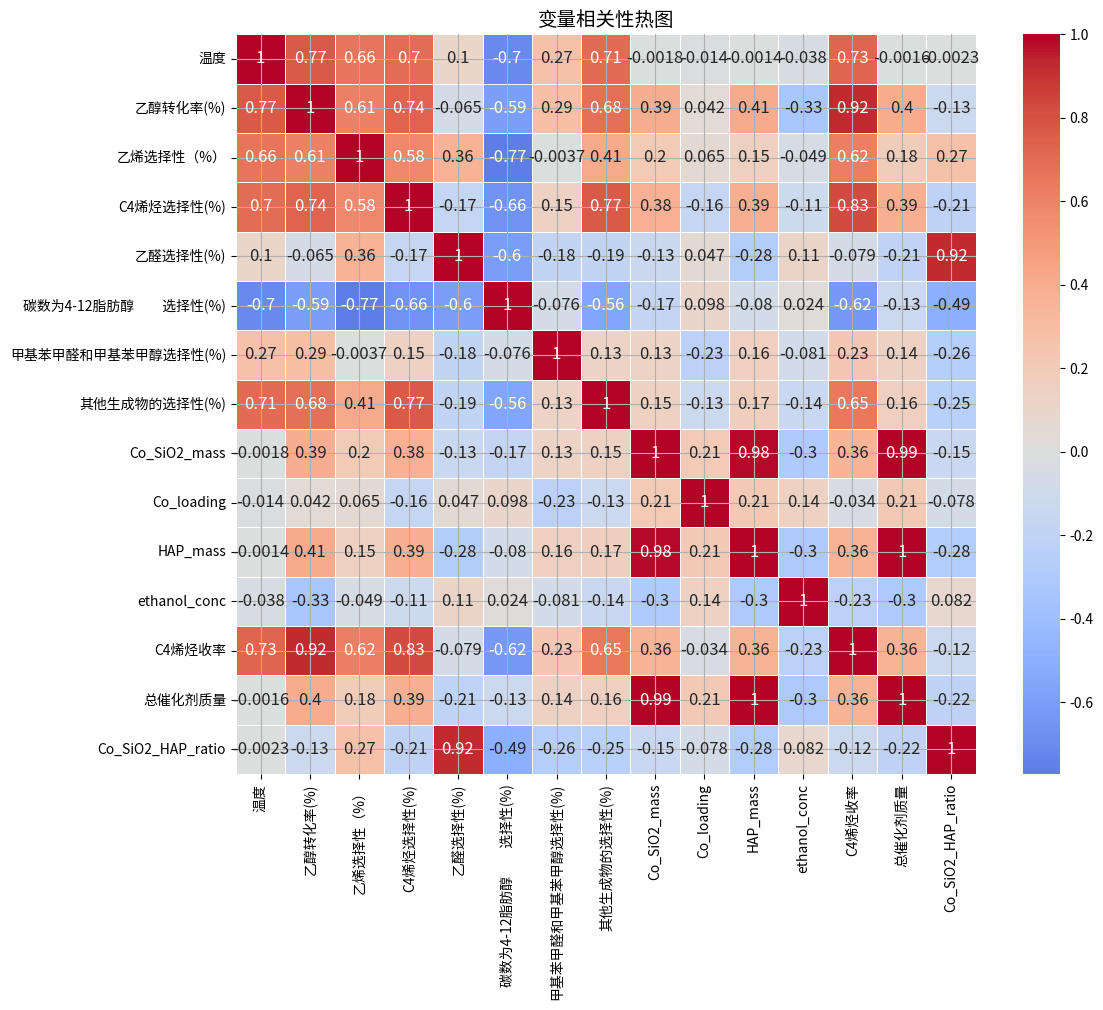


数据预处理完成！


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 读取原始数据文件
df1 = pd.read_excel('data/附件1.xlsx')
df2 = pd.read_excel('data/附件2.xlsx')

# 处理附件2的列名问题
df2.columns = ['时间(min)', '乙醇转化率(%)', '乙烯选择性(%)', 'C4烯烃选择性(%)', 
               '乙醛选择性(%)', '碳数为4-12脂肪醇选择性(%)', '甲基苯甲醛和甲基苯甲醇选择性(%)', '其他选择性(%)']
df2 = df2.dropna()  # 删除包含NaN的行

print("附件1数据维度:", df1.shape)
print("附件2数据维度:", df2.shape)

# 查看附件1数据结构
df1.head()

# 查看附件2数据结构  
df2.head()

# 检查数据基本信息
df1.info()

# 处理附件1的合并单元格结构
df1['催化剂组合编号'].fillna(method='ffill', inplace=True)
df1['催化剂组合'].fillna(method='ffill', inplace=True)

print("填充后缺失值:")
print(df1.isnull().sum())

# 查看所有催化剂组合格式
print("\n所有催化剂组合:")
print(df1['催化剂组合'].unique())

# 提取催化剂组合信息
def extract_catalyst_info(catalyst_combo):
    """提取催化剂组合的关键参数"""
    import re
    
    # 提取Co/SiO2质量
    co_mass_match = re.search(r'(\d+)mg.*?Co/SiO2', catalyst_combo)
    co_mass = int(co_mass_match.group(1)) if co_mass_match else 0
    
    # 提取Co负载量
    co_loading_match = re.search(r'(\d+\.?\d*)wt%Co/SiO2', catalyst_combo)
    co_loading = float(co_loading_match.group(1)) if co_loading_match else 0
    
    # 提取HAP质量
    if '无HAP' in catalyst_combo:
        hap_mass = 0
    else:
        hap_mass_match = re.search(r'(\d+)mg HAP', catalyst_combo)
        hap_mass = int(hap_mass_match.group(1)) if hap_mass_match else 0
    
    # 提取乙醇浓度
    ethanol_match = re.search(r'乙醇浓度(\d+\.?\d*)ml/min', catalyst_combo)
    ethanol_conc = float(ethanol_match.group(1)) if ethanol_match else 0
    
    return co_mass, co_loading, hap_mass, ethanol_conc

# 处理附件1数据
catalyst_info = df1['催化剂组合'].apply(extract_catalyst_info)
df1[['Co_SiO2_mass', 'Co_loading', 'HAP_mass', 'ethanol_conc']] = pd.DataFrame(catalyst_info.tolist())

# 计算C4烯烃收率
df1['C4烯烃收率'] = df1['乙醇转化率(%)'] * df1['C4烯烃选择性(%)'] / 100

# 计算总催化剂质量
df1['总催化剂质量'] = df1['Co_SiO2_mass'] + df1['HAP_mass']

# 计算Co/SiO2与HAP质量比
df1['Co_SiO2_HAP_ratio'] = df1['Co_SiO2_mass'] / (df1['HAP_mass'] + 1e-8)

# 添加装料方式标识
df1['装料方式'] = df1['催化剂组合编号'].apply(lambda x: 'I' if x.startswith('A') else 'II')

# 保存处理后的数据为CSV
df1.to_csv('data/附件1.csv', index=False, encoding='utf-8-sig')
df2.to_csv('data/附件2.csv', index=False, encoding='utf-8-sig')

print("数据处理完成并保存为CSV格式")
print(f"处理后附件1维度: {df1.shape}")
print(f"新增变量: {list(df1.columns[-6:])}")

# 显示处理后的关键统计信息
print("\n关键变量统计:")
key_vars = ['温度', '乙醇转化率(%)', 'C4烯烃选择性(%)', 'C4烯烃收率', 'Co_loading', 'ethanol_conc']
print(df1[key_vars].describe())

# 可视化数据分布
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, var in enumerate(key_vars):
    axes[i].hist(df1[var], bins=20, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{var}分布')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('频数')

plt.tight_layout()
plt.show()

# 相关性分析
numeric_cols = df1.select_dtypes(include=[np.number]).columns
correlation_matrix = df1[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('变量相关性热图')
plt.tight_layout()
plt.show()

print("\n数据预处理完成！")

相关系数矩阵:
                                 温度  乙醇转化率(%)  乙烯选择性（%）  C4烯烃选择性(%)  乙醛选择性(%)  \
温度                         1.000000  0.770595  0.663851    0.699849  0.100776   
乙醇转化率(%)                   0.770595  1.000000  0.607183    0.735317 -0.065102   
乙烯选择性（%）                   0.663851  0.607183  1.000000    0.579172  0.361412   
C4烯烃选择性(%)                 0.699849  0.735317  0.579172    1.000000 -0.167518   
乙醛选择性(%)                   0.100776 -0.065102  0.361412   -0.167518  1.000000   
碳数为4-12脂肪醇         选择性(%) -0.703187 -0.593538 -0.771299   -0.663430 -0.603024   
甲基苯甲醛和甲基苯甲醇选择性(%)          0.269495  0.285797 -0.003698    0.147369 -0.184033   
其他生成物的选择性(%)               0.708440  0.682366  0.414076    0.769934 -0.189016   
Co_SiO2_mass              -0.001772  0.394608  0.201429    0.379871 -0.134831   
Co_loading                -0.014189  0.041846  0.064647   -0.164957  0.046660   
HAP_mass                  -0.001385  0.406465  0.149272    0.387557 -0.275167   
ethanol_conc        

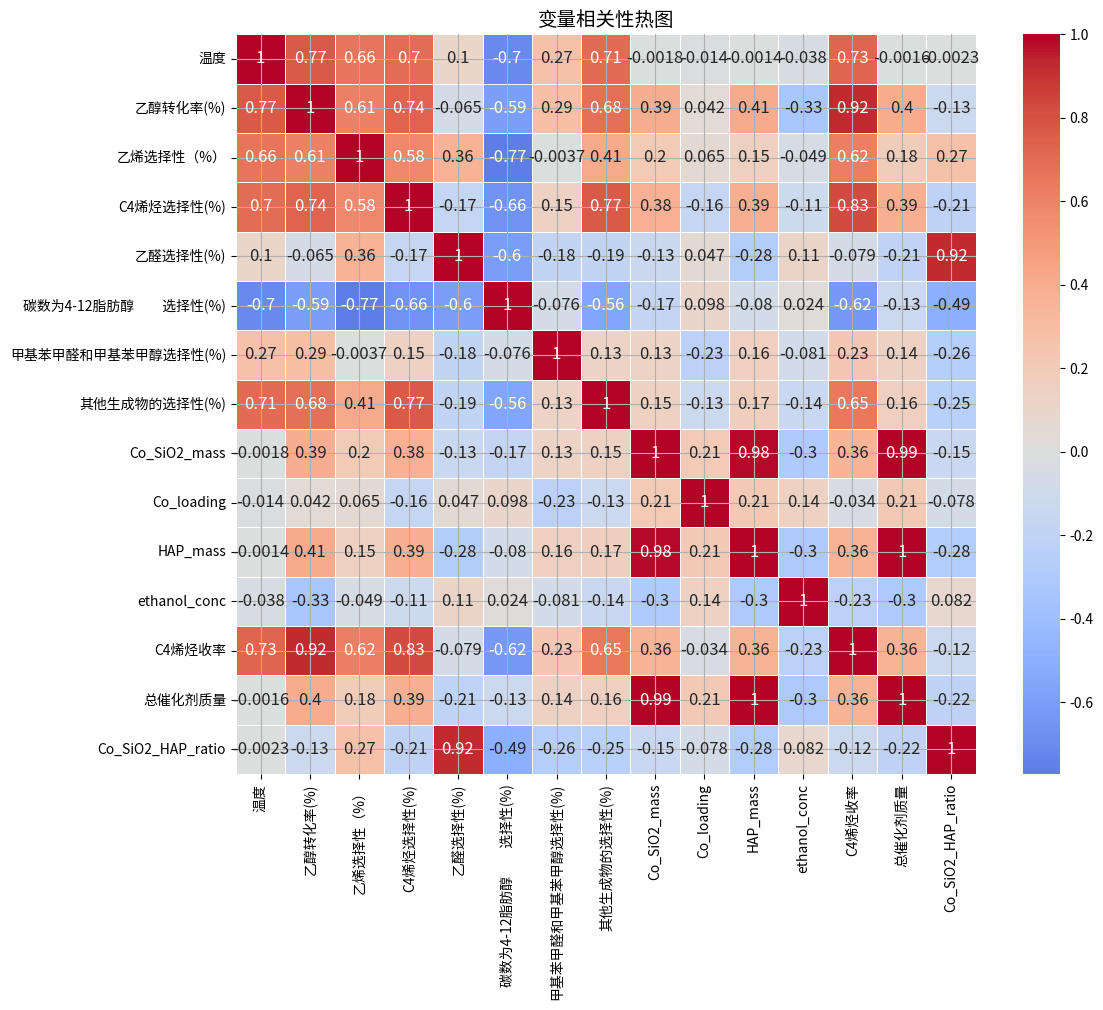

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 读取处理后的数据
df1 = pd.read_csv('data/附件1.csv')

# 选择数值型列进行相关性分析
numeric_cols = df1.select_dtypes(include=[np.number]).columns

# 计算相关系数矩阵
correlation_matrix = df1[numeric_cols].corr()

# 打印相关系数矩阵
print("相关系数矩阵:")
print(correlation_matrix)

# 可视化相关性热图
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('变量相关性热图')
plt.tight_layout()
plt.show()
